In [1]:
from fastai.vision.all import *

path = Path("dataset/gaussian_filtered_images/gaussian_filtered_images/")

In [2]:
dls = ImageDataLoaders.from_folder(path, seed=316, valid_pct=0.2, bs=32,
                                item_tfms=Resize(604),
                                   batch_tfms=aug_transforms(size=518))

In [3]:
# All models on timm
import timm
len(timm.list_models('*'))

991

In [4]:
timm.list_models('*dinov2*')

['vit_base_patch14_dinov2',
 'vit_giant_patch14_dinov2',
 'vit_large_patch14_dinov2',
 'vit_small_patch14_dinov2']

In [5]:
learn = vision_learner(dls, 'vit_small_patch14_dinov2', metrics=accuracy).to_fp16()

SuggestedLRs(valley=0.0006918309954926372)

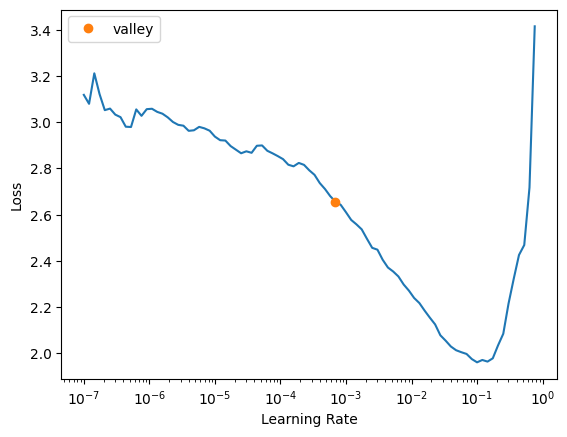

In [6]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,1.445417,0.683648,0.730874,00:27


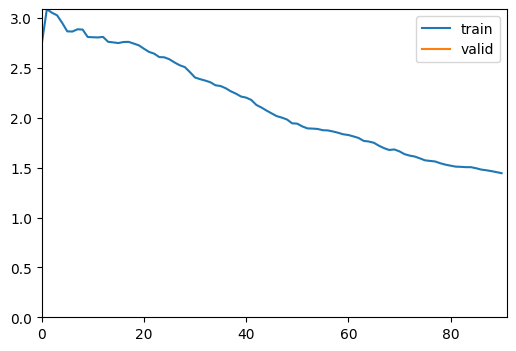

epoch,train_loss,valid_loss,accuracy,time
0,0.885561,0.592820,0.800546,00:32
1,0.811918,0.573381,0.785519,00:32
2,0.689701,0.517448,0.818306,00:32
3,0.591488,0.439778,0.840164,00:32
4,0.555226,0.435833,0.844262,00:32


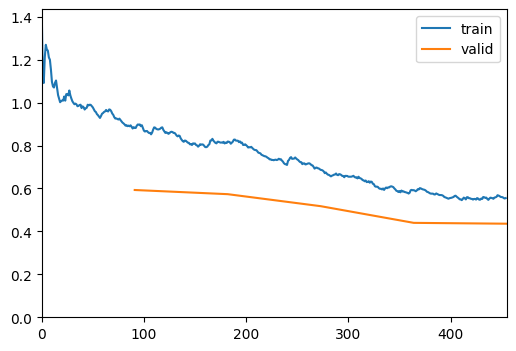

In [7]:
learn.fine_tune(5, base_lr=1e-3, cbs=[ShowGraphCallback()])

In [20]:
torch.save(learn.model[0].model.state_dict(), 'dinov2s_finetuned_feature.pth')

In [21]:
learn.model[0].model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identit

In [22]:
import torch
import timm

# Create the model architecture (without pretrained weights)
model = timm.create_model('vit_small_patch14_dinov2', pretrained=False)

# Load local model weights
model_weights_path = 'dinov2s_finetuned_feature.pth'
model.load_state_dict(torch.load(model_weights_path))


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identit

In [26]:
from timm.utils.model import reparameterize_model
finetuned_model = reparameterize_model(learn.model[0].model)
finetuned_model.to("cpu")

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identit

In [30]:
import torch.onnx
torch.onnx.export(finetuned_model,
                 torch.rand(1, 3, 518, 518, requires_grad=True),
                 "vit_small_patch14_dinov2.lvd142m_finetuned.onnx",
                 export_params=True,
                 opset_version=16,
                 do_constant_folding=True,
                 input_names=['input'],
                 output_names=['output'], 
                 dynamic_axes={'input' : {0 : 'batch_size'},   
                               'output' : {0 : 'batch_size'}}
)

============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 1 ERROR ========================
ERROR: missing-standard-symbolic-function
Exporting the operator 'aten::scaled_dot_product_attention' to ONNX opset version 16 is not supported. Please feel free to request support or submit a pull request on PyTorch GitHub: https://github.com/pytorch/pytorch/issues.
None
<Set verbose=True to see more details>




UnsupportedOperatorError: Exporting the operator 'aten::scaled_dot_product_attention' to ONNX opset version 16 is not supported. Please feel free to request support or submit a pull request on PyTorch GitHub: https://github.com/pytorch/pytorch/issues.